In [40]:
#This is based on https://github.com/aniruddhraghu/sepsisrl/blob/master/preprocessing

In [20]:
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import _pickle as pickle

In [21]:
df = pd.read_csv('D:/MIMICIII/Created Data/Fresh_start/discretised_input_data_MIMIC_mimiciii.csv')
#df_train = pd.read_csv('D:/MIMICIII/Created Data/rl_train_set_scaled.csv')
#df_val =  pd.read_csv('D:/MIMICIII/Created Data/rl_val_set_scaled.csv')
#df_test = pd.read_csv('D:/MIMICIII/Created Data/rl_test_set_scaled.csv')
#df_pregnant = pd.read_csv('D:/MIMICIII/Created Data/rl_old_set_scaled.csv')

In [22]:
df.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,died_within_48h_of_out_time,mortality_90d,...,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,SOFA,SIRS,vaso_input,iv_input,action
0,1,3,7245486000,0,17639.8264,0,0,0.0,NaN,1.0,...,5127.0,50.0,13617.0,520.0,-8490.0,6,2,0.0,2.0,10
1,2,3,7245500400,0,17639.8264,0,0,0.0,NaN,1.0,...,5177.0,50.0,13982.0,365.0,-8805.0,6,2,0.0,2.0,10
2,3,3,7245514800,0,17639.8264,0,0,0.0,NaN,1.0,...,5227.0,50.0,14262.0,280.0,-9035.0,6,2,0.0,2.0,10
3,4,3,7245529200,0,17639.8264,0,0,0.0,NaN,1.0,...,5277.0,50.0,14602.0,340.0,-9325.0,6,1,0.0,2.0,10
4,5,3,7245543600,0,17639.8264,0,0,0.0,NaN,1.0,...,5327.0,50.0,15142.0,540.0,-9815.0,6,2,0.0,2.0,10


In [23]:
c0 = -0.1/4
c1 = -0.5/4
c2 = -2

In [24]:
#Add rewards
df["mortality_90d"] = df["mortality_90d"].fillna(0)
df['reward'] = 0
for i in df.index:
    if i == 0:
        continue
    # add intermediate rewards
    elif df.loc[i, 'icustayid'] == df.loc[i-1, 'icustayid']:
        sofa_cur = df.loc[i,'SOFA']
        sofa_prev = df.loc[i-1,'SOFA']
        lact_cur = df.loc[i,'Arterial_lactate']
        lact_prev = df.loc[i-1,'Arterial_lactate']
        reward = 0
        if sofa_cur == sofa_prev and sofa_cur != 0:
            reward += c0
        reward += c1*(sofa_cur-sofa_prev)
        reward += c2*np.tanh(lact_cur - lact_prev)
        df.loc[i-1,'reward'] = reward
    
    #Add final rewards
    elif df.loc[i, 'icustayid'] != df.loc[i-1, 'icustayid']:
        if df.loc[i-1, 'mortality_90d'] == 1.0:
                df.loc[i-1,'reward'] = -15
                
        elif df.loc[i-1, 'mortality_90d'] == 0.0:
            df.loc[i-1,'reward'] = 15
        else:
            print("error in row", i-1)
    elif i % 10000 == 0:
        print(i)
if df.loc[len(df)-1, 'mortality_90d'] == 1.0:
    df.loc[len(df)-1, 'reward'] = -15
elif df.loc[len(df)-1, 'mortality_90d'] == 0.0:
     df.loc[len(df)-1, 'reward'] = 15
print(df['reward'].value_counts())

print(df['reward'].value_counts())

-0.025000     49804
 0.125000     17236
 15.000000    16040
-0.125000     15165
 0.250000      8276
              ...  
-0.116671         1
 2.853070         1
-0.571398         1
 0.344274         1
-0.197695         1
Name: reward, Length: 44531, dtype: int64
-0.025000     49804
 0.125000     17236
 15.000000    16040
-0.125000     15165
 0.250000      8276
              ...  
-0.116671         1
 2.853070         1
-0.571398         1
 0.344274         1
-0.197695         1
Name: reward, Length: 44531, dtype: int64


In [25]:
#df["mortality_90d"] = df["mortality_90d"].fillna(0)
#Set final rewards
#df['reward'] = 0
#for i in df.index:
#    if i == 0:
#        continue
#    else:
#        if df.loc[i, 'icustayid'] != df.loc[i-1, 'icustayid']:
#            
#            if df.loc[i-1, 'mortality_90d'] == 1.0:
#                df.loc[i-1,'reward'] = -15
#                
#            elif df.loc[i-1, 'mortality_90d'] == 0.0:
#                df.loc[i-1,'reward'] = 15
#            else:
#                print("error in row", i-1)
#if df.loc[len(df)-1, 'mortality_90d'] == 1.0:
#    df.loc[len(df)-1, 'reward'] = -15
#elif df.loc[len(df)-1, 'mortality_90d'] == 0.0:
#     df.loc[len(df)-1, 'reward'] = 15
#print(df['reward'].value_counts())

In [26]:
# Smaller rewards to improve comparisons

#df.loc[df['reward'] > 15,'reward'] = 15
#df.loc[df['reward'] < -15,'reward'] = -15

#df_train.loc[df_train['reward'] > 15,'reward'] = 15
#df_train.loc[df_train['reward'] < -15,'reward'] = -15

#df_val.loc[df_val['reward'] > 15,'reward'] = 15
#df_val.loc[df_val['reward'] < -15,'reward'] = -15

#df_test.loc[df_test['reward'] > 15,'reward'] = 15
#df_test.loc[df_test['reward'] < -15,'reward'] = -15

#df_pregnant.loc[df_pregnant['reward'] > 15,'reward'] = 15
#df_pregnant.loc[df_pregnant['reward'] < -15,'reward'] = -15

In [27]:
#orig_df = pd.read_csv('D:/MIMICIII/Matlab/pre_process_data.csv')

In [28]:
#len(orig_df)

In [29]:
#c0 = -0.1/4
#c1 = -0.5/4
#c2 = -2

In [30]:
# add intermediate rewards
#orig_df['shaped_reward'] = 0
#for i in orig_df.index:
#    if i == 0:
#        continue
#    if orig_df.loc[i, 'icustayid'] == orig_df.loc[i-1, 'icustayid']:
#        sofa_cur = orig_df.loc[i,'SOFA']
#        sofa_prev = orig_df.loc[i-1,'SOFA']
#        lact_cur = orig_df.loc[i,'Arterial_lactate']
#        lact_prev = orig_df.loc[i-1,'Arterial_lactate']
#        reward = 0
#        if sofa_cur == sofa_prev and sofa_cur != 0:
#            reward += c0
#        reward += c1*(sofa_cur-sofa_prev)
#        reward += c2*np.tanh(lact_cur - lact_prev)
#        orig_df.loc[i-1,'shaped_reward'] = reward
#    if i % 10000 == 0:
#        print(i)


#print(orig_df['shaped_reward'].value_counts())

<AxesSubplot:>

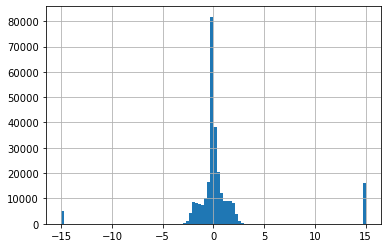

In [31]:
%matplotlib inline
df['reward'].hist(bins=100)

In [32]:
#train_ids = df_train['icustayid'].unique()
#val_ids = df_val['icustayid'].unique()
#test_ids = df_test['icustayid'].unique()
#preg_ids = df_pregnant["icustayid"].unique()
#df_ids = df["icustayid"].unique()

In [33]:
#train_rewards = orig_df.loc[orig_df['icustayid'].isin(train_ids)]['shaped_reward']

In [34]:
#val_rewards = orig_df.loc[orig_df['icustayid'].isin(val_ids)]['shaped_reward']

In [35]:
#test_rewards = orig_df.loc[orig_df['icustayid'].isin(test_ids)]['shaped_reward']
#pregnant_rewards = orig_df.loc[orig_df['icustayid'].isin(preg_ids)]['shaped_reward']

In [36]:
#df_rewards = orig_df.loc[orig_df['icustayid'].isin(df_ids)]['shaped_reward']

In [37]:
#len(df_train) + len(df_test) + len(df_val)
#len(df_pregnant)

In [38]:
#len(pregnant_rewards)

In [39]:
#len(orig_df['shaped_reward'])

In [40]:
#df_train['reward'] += np.array(train_rewards)
#df_val['reward'] += np.array(val_rewards)
#df_test['reward'] += np.array(test_rewards)
#df_pregnant['reward'] += np.array(pregnant_rewards)
#df['reward'] += np.array(df_rewards)

In [41]:
#df_train.to_csv('D:/MIMICIII/Created Data/rl_train_data_final_cont.csv',index=False)
#df_val.to_csv('D:/MIMICIII/Created Data/rl_val_data_final_cont.csv', index=False)
#df_test.to_csv('D:/MIMICIII/Created Data/rl_test_data_final_cont.csv',index=False)
#df_pregnant.to_csv('D:/MIMICIII/Created Data/rl_old_data_final_cont.csv',index=False)
df.to_csv('D:/MIMICIII/Created Data/Fresh_start/did_MIMIC_mimiciii_with_rewards.csv',index=False)

In [64]:
#df_train['reward'].describe()